# Windkessel

In [1]:
import numpy as np
import torch


In [2]:
import pandas as pd

In [3]:
import matplotlib
import matplotlib.pyplot as plt

font = {'family' : 'Liberation Sans',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

In [4]:
import sys
sys.path.insert(0, './python')

In [5]:
from windkessel import model

### Получение $ Q_{in}(t) $ по $ P(t) $

In [6]:
test_model = model.WindkesselModel()

In [7]:
from scipy.integrate import solve_ivp

In [8]:
def plot_x_y(x, y, x_label="x", y_label="y"):
    fig = plt.figure()
    ax = fig.gca()
    fig.set_figheight(12)
    fig.set_figwidth(16)
    ax.grid(color='#000000', alpha=0.15, linestyle='-', linewidth=1, which='major')
    ax.grid(color='#000000', alpha=0.1, linestyle='-', linewidth=0.5, which='minor')
    
    ax.plot(x, y)
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

In [9]:
tp = pd.read_csv('data/data.csv', header = None, sep = ',')

In [10]:
# t в секундах, p в мм.рт.ст.
tp = tp.rename({0 :'t', 1: 'p'}, axis = 1)
tp = tp.sort_values(by=['t'])

In [11]:
#Из эксперимента
T = np.array(tp['t'])
P = np.array(tp['p'])

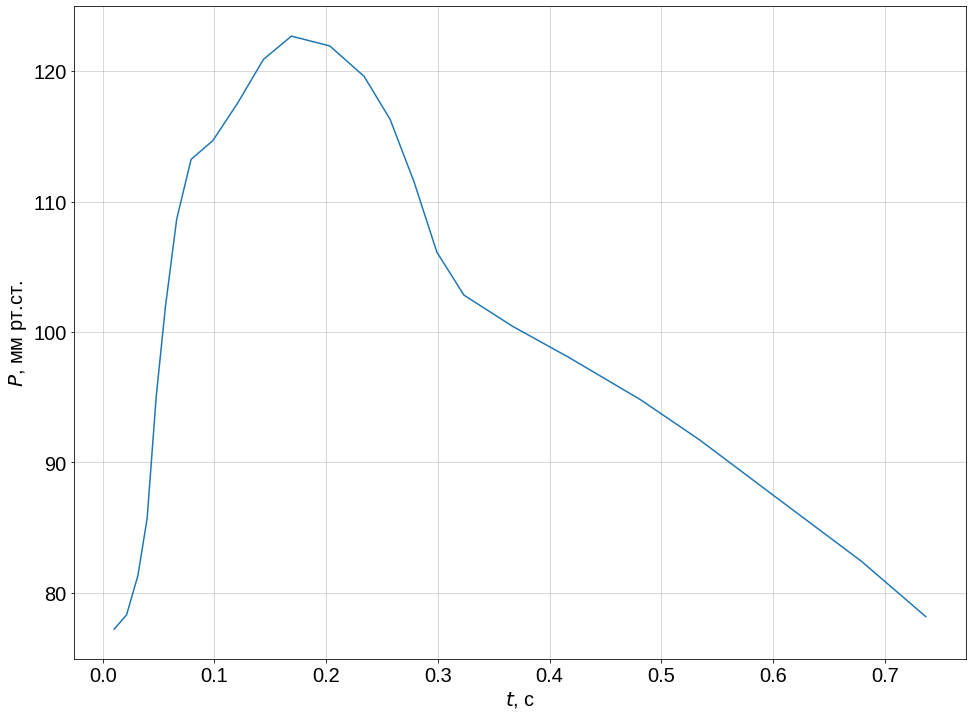

In [12]:
plot_x_y(T, P, "$ t $, с", "$ P $, мм рт.ст.")

In [13]:
def Q_in_rhs(t, Q_in):
    return test_model.Q_in_rhs(t, Q_in).detach().numpy()

In [14]:
test_model.set_P(T, P)

In [15]:
n_cycles = 5
new_T = np.linspace(T[0], T[0] + (T[-1] - T[0]) * n_cycles, T.shape[0] * n_cycles)

In [16]:
result = solve_ivp(Q_in_rhs, (new_T[0], new_T[-1]), np.array([0.0]), t_eval = new_T)

In [17]:
numerical_Q_in = result.y[0]

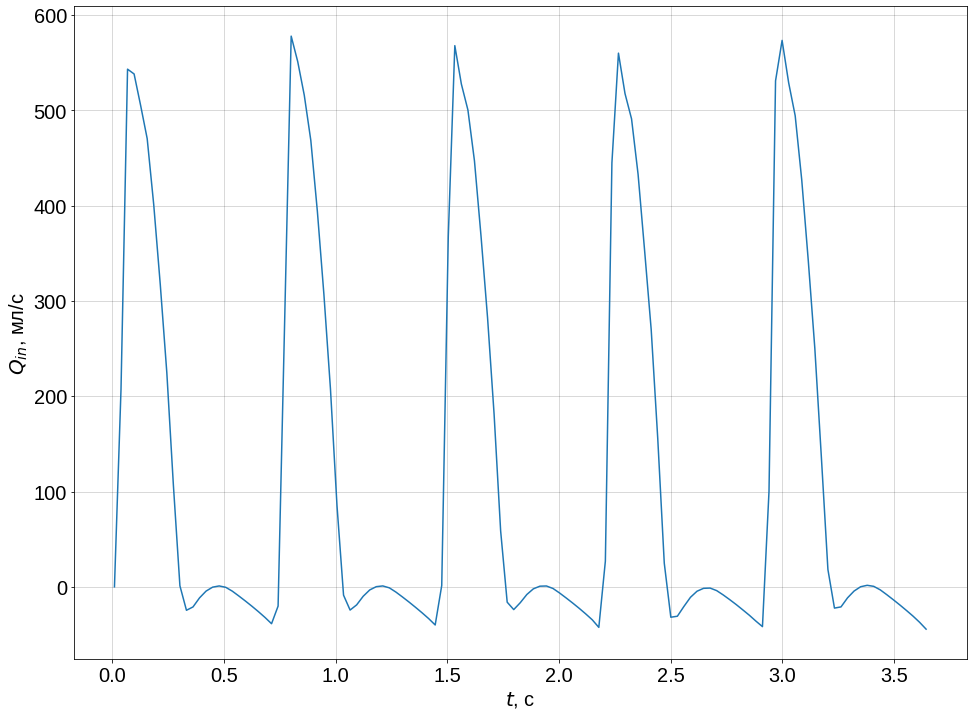

In [19]:
plot_x_y(new_T, numerical_Q_in, "$ t $, с", "$ Q_{in} $, мл/с")